In [1]:
import glob
from functools import reduce
import cartopy.crs as ccrs
import cartopy.feature as cf
# import cftime as cf
import geopandas as gp
import matplotlib as mpl
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pooch
import regionmask
import xarray as xr
from cartopy.feature import NaturalEarthFeature
from IPython.display import Markdown
from matplotlib import colors
import geopandas as gpd
import warnings


/apps/brussel/RL8/broadwell/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# Prepare for units transformation from mm/year to m3/year
mm_to_m = 10**(-3)
mm_per_s_to_mm_per_day = 86400.0

lnd_area_ctsm_f09_g17 =  xr.open_dataset('/user/brussel/105/vsc10535/VSC10535/Cheyenne_Work/2024_Taranu_etal_GMD_data/area_lnd.nc', decode_times=False)['area'].values.flatten()*(10**6) # transform from km2 to m2
mask_lnd_ctsm_f09_g17 = xr.open_dataset('/user/brussel/105/vsc10535/VSC10535/Cheyenne_Work/2024_Taranu_etal_GMD_data/landmask.nc', decode_times=False)['landmask'].values.flatten()
ctsm_f09_g17_mm_per_year_to_km3_per_year_transform = mm_per_s_to_mm_per_day*mm_to_m*lnd_area_ctsm_f09_g17/(10**9)

lon_ctsm_f09_g17 = xr.open_dataset('/user/brussel/105/vsc10535/VSC10535/Cheyenne_Work/2024_Taranu_etal_GMD_data/surfdata/surfdata_for_each_year/1971/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1971_c230217.nc')['LONGXY'].values[0]
lat_ctsm_f09_g17 = xr.open_dataset('/user/brussel/105/vsc10535/VSC10535/Cheyenne_Work/2024_Taranu_etal_GMD_data/surfdata/surfdata_for_each_year/1971/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1971_c230217.nc')['LATIXY'].values[:,0]

In [3]:
# Read the output data for the simulation with sector water usage on
path_simulation_data_with_sector_water_abstractions = "/user/brussel/105/vsc10535/VSC10535/Cheyenne_Work/2024_Taranu_etal_GMD_data/paper1_sectorwater_run.clm2.h1.1971-2010.nc"
output_data_sectorwater_simulation = xr.open_dataset(path_simulation_data_with_sector_water_abstractions, decode_times=False)

In [4]:
warnings.filterwarnings('ignore')
# load Natural Earth countries dataset included in geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Define the regions
region_dict = {
    'North America': ['United States of America', 'Canada', 'Greenland'],
    'Central America': ['Guatemala', 'Belize', 'El Salvador', 'Honduras', 'Nicaragua', 'Costa Rica', 'Panama', 'Mexico'],
    'South America': ['Colombia', 'Venezuela', 'Guyana', 'Suriname', 'Ecuador', 'Peru', 'Bolivia', 'Brazil', 'Paraguay', 'Uruguay', 'Chile', 'Argentina'],
    'West Europe': ['Portugal', 'Spain', 'France', 'United Kingdom', 'Ireland', 'Belgium', 'Netherlands', 'Luxembourg', 'Germany', 'Switzerland', 'Austria', 'Monaco', 'Liechtenstein'],
    'Eastern Europe and Central Asia': ['Poland', 'Czech Republic', 'Slovakia', 'Hungary', 'Romania', 'Moldova', 'Ukraine', 'Belarus', 'Lithuania', 'Latvia', 'Estonia', 'Russia', 'Slovenia', 'Croatia', 'Bosnia and Herz.', 'Serbia', 'Kosovo', 'Montenegro', 'Albania', 'Macedonia', 'Bulgaria', 'Greece', 'Cyprus', 'Turkey', 'Georgia', 'Armenia', 'Azerbaijan', 'Kazakhstan', 'Uzbekistan', 'Turkmenistan', 'Tajikistan', 'Kyrgyzstan'],
    'Middle East': ['Lebanon', 'Israel', 'Palestine', 'Jordan', 'Syria', 'Iraq', 'Iran', 'Kuwait', 'Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates', 'Qatar', 'Bahrain'],
    'North Africa': ['Egypt', 'Libya', 'Tunisia', 'Algeria', 'Morocco', 'Western Sahara', 'Mauritania'],
    'South Africa': ['Namibia', 'Botswana', 'South Africa', 'Lesotho', 'Swaziland', 'Zimbabwe', 'Mozambique', 'Malawi', 'Zambia', 'Angola'],
    'East Asia': ['China', 'North Korea', 'South Korea', 'Mongolia', 'Japan', 'Taiwan'],
    'Southeast Asia': ['Myanmar', 'Thailand', 'Laos', 'Cambodia', 'Vietnam', 'Malaysia', 'Singapore', 'Brunei', 'Indonesia', 'Timor-Leste', 'Philippines'],
    'South Asia': ['Afghanistan', 'Pakistan', 'India', 'Bangladesh', 'Bhutan', 'Nepal', 'Sri Lanka', 'Maldives'],
    'Australia/Pacific': ['Australia', 'Papua New Guinea', 'New Zealand', 'Solomon Is.', 'Vanuatu', 'Fiji', 'New Caledonia', 'Samoa', 'Tonga']
}

# Create an empty GeoDataFrame to store region geometries
regions_gdf = gpd.GeoDataFrame(columns=['region', 'geometry'])

# Create region geometries by unifying country geometries within each region
for region, countries in region_dict.items():
    geometries = world.loc[world['name'].isin(countries), 'geometry']
    regions_gdf = regions_gdf.append({
        'region': region, 
        'geometry': geometries.unary_union
    }, ignore_index=True)

# Create a regionmask Regions object
regions = regionmask.from_geopandas(regions_gdf, names='region', name='custom')

# Create a mask using the latitude and longitude values of your data
mask = regions.mask(lon_ctsm_f09_g17, lat_ctsm_f09_g17)

# Now, when you compute the sum over the 'lon' and 'lat' dimensions, you can also group by the 'mask' dimension
# This will compute the sum over each region
output_data_sectorwater_simulation.coords['region'] = (('lat', 'lon'), mask.data)

# Define the list of variables we want to compute total annual amount for (withdrawal and consumption for each sector, except irrigation, for which only withdrawal is available)
list_of_variables_to_extract_expected = ["DOM_EXPECTED_WITHD", "LIV_EXPECTED_WITHD", "ELEC_EXPECTED_WITHD", "MFC_EXPECTED_WITHD", "MIN_EXPECTED_WITHD", "DOM_EXPECTED_CONS", "LIV_EXPECTED_CONS", "ELEC_EXPECTED_CONS", "MFC_EXPECTED_CONS", "MIN_EXPECTED_CONS", "QIRRIG_DEMAND"]
list_of_variables_to_extract_actual = ["DOM_ACTUAL_WITHD", "LIV_ACTUAL_WITHD", "ELEC_ACTUAL_WITHD", "MFC_ACTUAL_WITHD", "MIN_ACTUAL_WITHD", "DOM_ACTUAL_CONS", "LIV_ACTUAL_CONS", "ELEC_ACTUAL_CONS", "MFC_ACTUAL_CONS", "MIN_ACTUAL_CONS", "QIRRIG_FROM_SURFACE"]

# Define an array to store global annual withdrawal and consumption ammounts for each sector
time_series_water_abstraction_fluxes_expected = np.zeros((11,38, 12))
time_series_water_abstraction_fluxes_actual = np.zeros((11,38, 12))

# Define moving time window for each window:
init_time = 0
end_time  = 365
step = 365

# You can now loop over your variables and years as before, but replace the np.nansum with sum over 'lon' and 'lat' dimensions and group by 'region'
for year in range(1973, 2011):
    for variable in range(0, 11):
        # for expected fluxes
        data_expected = output_data_sectorwater_simulation[list_of_variables_to_extract_expected[variable]][init_time:end_time, :, :]
        yearly_values_expected = (data_expected.sum(dim='time') * ctsm_f09_g17_mm_per_year_to_km3_per_year_transform.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])))
        yearly_values_grouped_by_region_expected = yearly_values_expected.groupby('region').sum(dim='stacked_lat_lon')
        time_series_water_abstraction_fluxes_expected[variable, year - 1973, :] = yearly_values_grouped_by_region_expected.values[:]
        # for actual fluxes
        data_actual = output_data_sectorwater_simulation[list_of_variables_to_extract_actual[variable]][init_time:end_time, :, :]
        yearly_values_actual = (data_actual.sum(dim='time') * ctsm_f09_g17_mm_per_year_to_km3_per_year_transform.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])))
        yearly_values_grouped_by_region_actual = yearly_values_actual.groupby('region').sum(dim='stacked_lat_lon')
        time_series_water_abstraction_fluxes_actual[variable, year - 1973, :] = yearly_values_grouped_by_region_actual.values[:]
    init_time += step
    end_time += step
    print("Year completed: " + str(year))


Year completed: 1973
Year completed: 1974
Year completed: 1975
Year completed: 1976
Year completed: 1977
Year completed: 1978
Year completed: 1979
Year completed: 1980
Year completed: 1981
Year completed: 1982
Year completed: 1983
Year completed: 1984
Year completed: 1985
Year completed: 1986
Year completed: 1987
Year completed: 1988
Year completed: 1989
Year completed: 1990
Year completed: 1991
Year completed: 1992
Year completed: 1993
Year completed: 1994
Year completed: 1995
Year completed: 1996
Year completed: 1997
Year completed: 1998
Year completed: 1999
Year completed: 2000
Year completed: 2001
Year completed: 2002
Year completed: 2003
Year completed: 2004
Year completed: 2005
Year completed: 2006
Year completed: 2007
Year completed: 2008
Year completed: 2009
Year completed: 2010


In [6]:
warnings.filterwarnings('ignore')

# Define the list of withdrawal variables and corresponding sectors
variables_withd = [ "QIRRIG_DEMAND", "DOM_EXPECTED_WITHD", "LIV_EXPECTED_WITHD", "ELEC_EXPECTED_WITHD", "MFC_EXPECTED_WITHD", "MIN_EXPECTED_WITHD"]
sectors = ["Irrigation", "Domestic", "Livestock", "Electricity", "Manufacturing", "Mining"]
colors = ["blue", "orange", "green", "red", "purple", "black"]

zero_line = np.zeros(38)
years = np.linspace(1973,2010,38)

df = pd.DataFrame(columns=['variable', 'year', 'region', 'value'])

for i, variable in enumerate(list_of_variables_to_extract_expected):
    for j, year in enumerate(range(1973, 2011)):
        for k, region in enumerate(region_dict.keys()):
            value = time_series_water_abstraction_fluxes_expected[i, j, k]
            df = df.append({'variable': variable, 'year': year, 'region': region, 'value': value}, ignore_index=True)

# Filter the DataFrame for withdrawal variables
df_withd = df[df['variable'].isin(variables_withd)]

# Set up the figure with 12 subplots
fig, axs = plt.subplots(4, 3, figsize=(15, 15), sharex=True)
axs = axs.flatten()

# Loop over regions
for i, region in enumerate(region_dict.keys()):
    ax = axs[i]
    
    # Prepare cumulative data for each sector
    cumulative_data = pd.DataFrame(columns=sectors)
    for sector, variable in zip(sectors, variables_withd):
        # Filter the DataFrame for the current sector and region and add to cumulative_data
        sector_data = df_withd[(df_withd['variable'] == variable) & (df_withd['region'] == region)]['value'].values
        if sector == 'Irrigation':
            sector_data = pd.Series(sector_data).rolling(window=10, min_periods=1).mean().values  # apply moving window averaging for 'Irrigation'
        cumulative_data[sector] = sector_data
        
    cumulative_sum = cumulative_data.cumsum(axis=1) # compute cumulative sum over sectors

    # Plot the cumulative data
    for sector, color in zip(sectors, colors):
        ax.plot(years, cumulative_sum[sector], label=sector, color=color)

        if sector == sectors[0]: # For the first sector, fill between the line and zero
            ax.fill_between(years, zero_line, np.array(cumulative_sum[sector].values[:], dtype='float32'), alpha=0.1, color=color)
        else: # For the rest, fill between the line and the previous sector's line
            ax.fill_between(years, np.array(cumulative_sum[sectors[sectors.index(sector)-1]], dtype='float32'), np.array(cumulative_sum[sector], dtype='float32'), alpha=0.1, color=color)
    
    ax.set_title(region)
    ax.set_ylabel('Cumulative Expected Water Withdrawal (km3/year)')
    # ax.legend()

plt.tight_layout()
plt.show()


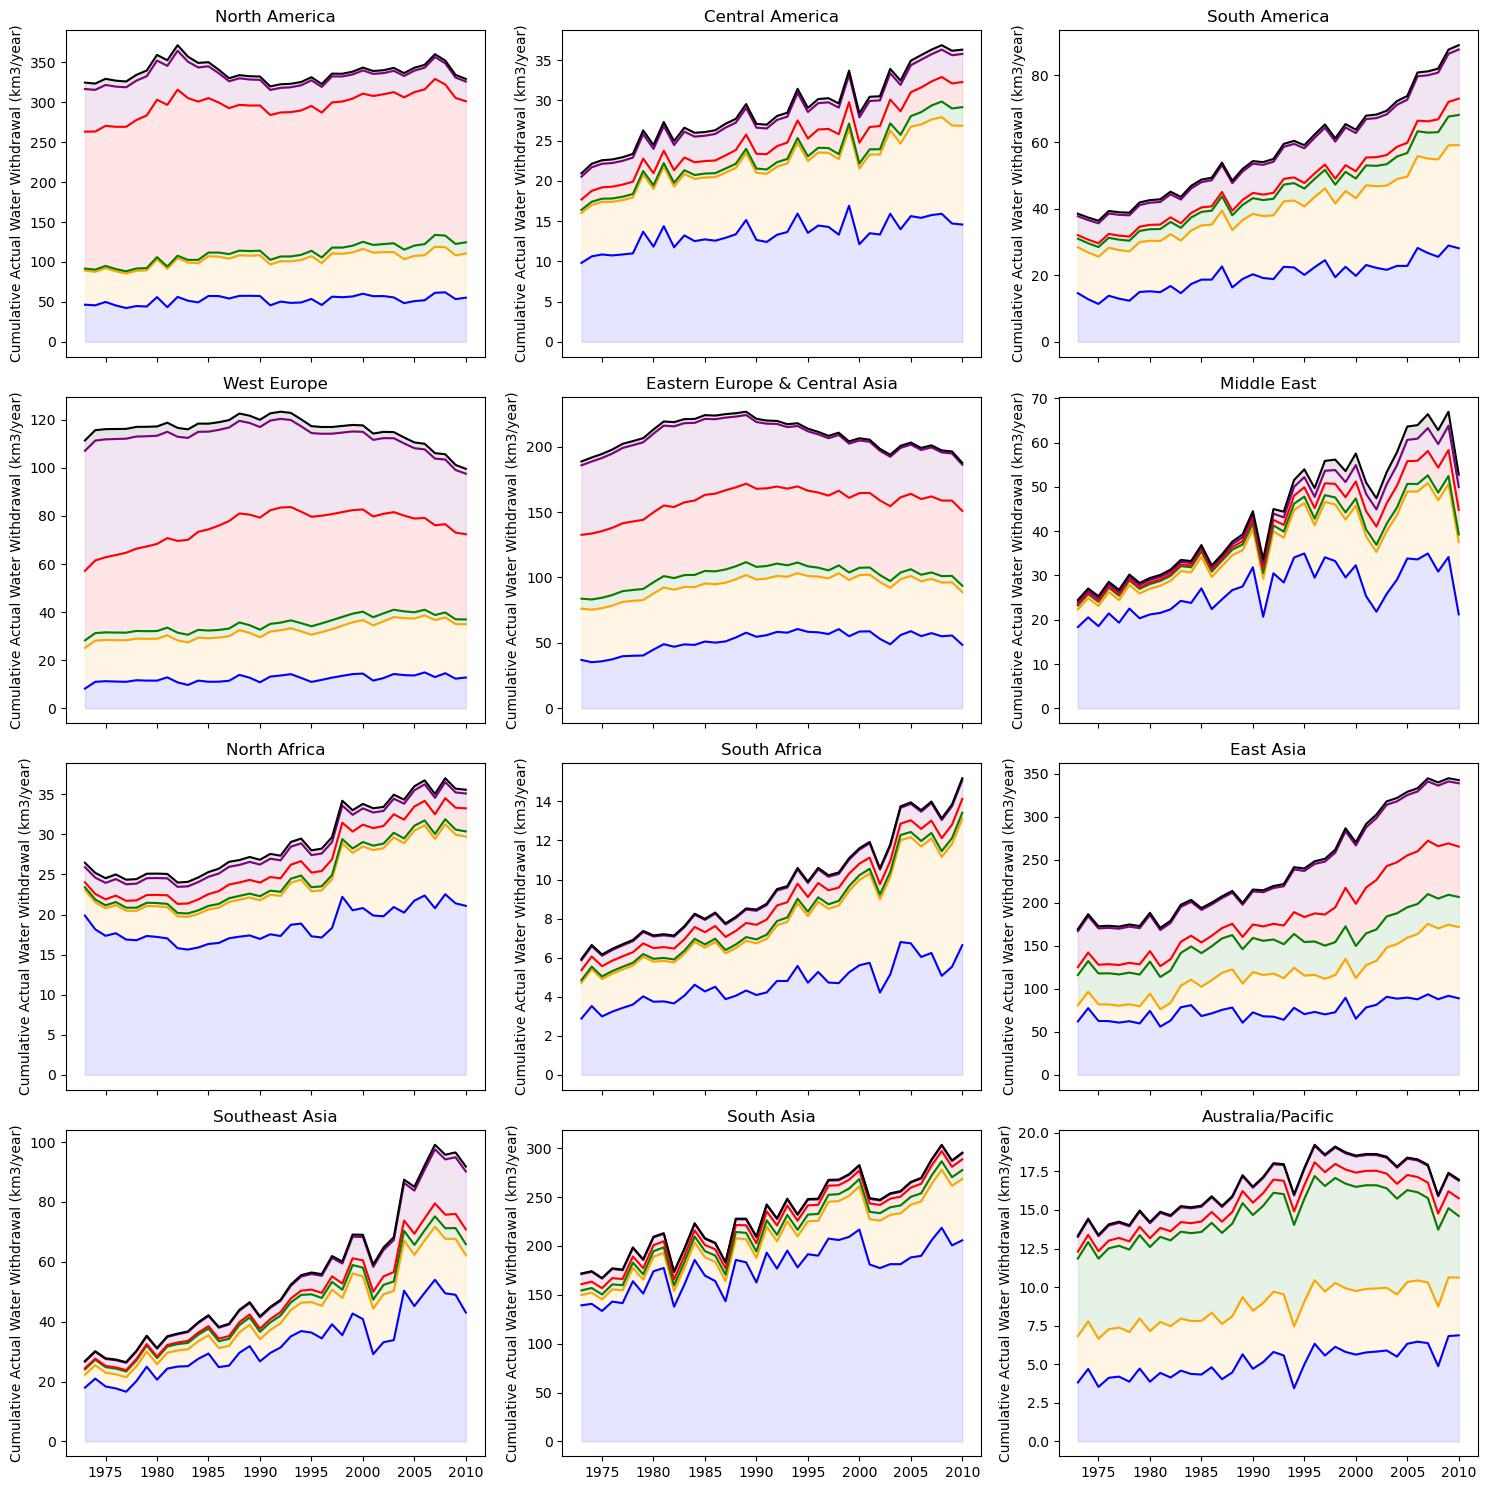

In [39]:
warnings.filterwarnings('ignore')

# Define the list of withdrawal variables and corresponding sectors
variables_withd = [ "QIRRIG_FROM_SURFACE", "DOM_ACTUAL_WITHD", "LIV_ACTUAL_WITHD", "ELEC_ACTUAL_WITHD", "MFC_ACTUAL_WITHD", "MIN_ACTUAL_WITHD"]
sectors = ["Irrigation", "Domestic", "Livestock", "Electricity", "Manufacturing", "Mining"]
colors = ["blue", "orange", "green", "red", "purple", "black"]

zero_line = np.zeros(38)
years = np.linspace(1973,2010,38)

df = pd.DataFrame(columns=['variable', 'year', 'region', 'value'])

for i, variable in enumerate(list_of_variables_to_extract_actual):
    for j, year in enumerate(range(1973, 2011)):
        for k, region in enumerate(region_dict.keys()):
            value = time_series_water_abstraction_fluxes_actual[i, j, k]
            df = df.append({'variable': variable, 'year': year, 'region': region, 'value': value}, ignore_index=True)

# Filter the DataFrame for withdrawal variables
df_withd = df[df['variable'].isin(variables_withd)]

# Set up the figure with 12 subplots
fig, axs = plt.subplots(4, 3, figsize=(15, 15), sharex=True)
axs = axs.flatten()

# Loop over regions
for i, region in enumerate(region_dict.keys()):
    ax = axs[i]
    
    # Prepare cumulative data for each sector
    cumulative_data = pd.DataFrame(columns=sectors)
    for sector, variable in zip(sectors, variables_withd):
        # Filter the DataFrame for the current sector and region and add to cumulative_data
        sector_data = df_withd[(df_withd['variable'] == variable) & (df_withd['region'] == region)]['value'].values
        if sector == 'Irrigation':
            sector_data = pd.Series(sector_data).rolling(window=1, min_periods=1).mean().values  # apply moving window averaging for 'Irrigation'
        cumulative_data[sector] = sector_data
        
    cumulative_sum = cumulative_data.cumsum(axis=1) # compute cumulative sum over sectors

    # Plot the cumulative data
    for sector, color in zip(sectors, colors):
        ax.plot(years, cumulative_sum[sector], label=sector, color=color)

        if sector == sectors[0]: # For the first sector, fill between the line and zero
            ax.fill_between(years, zero_line, np.array(cumulative_sum[sector].values[:], dtype='float32'), alpha=0.1, color=color)
        else: # For the rest, fill between the line and the previous sector's line
            ax.fill_between(years, np.array(cumulative_sum[sectors[sectors.index(sector)-1]], dtype='float32'), np.array(cumulative_sum[sector], dtype='float32'), alpha=0.1, color=color)
    
    ax.set_title(region)
    ax.set_ylabel('Cumulative Actual Water Withdrawal (km3/year)')
    # ax.legend()

plt.tight_layout()
plt.show()


In [7]:
warnings.filterwarnings('ignore')

# Define the list of withdrawal variables and corresponding sectors
variables_withd = [ "QIRRIG_FROM_SURFACE", "DOM_ACTUAL_WITHD", "LIV_ACTUAL_WITHD", "ELEC_ACTUAL_WITHD", "MFC_ACTUAL_WITHD", "MIN_ACTUAL_WITHD"]
sectors = ["Irrigation", "Domestic", "Livestock", "Electricity", "Manufacturing", "Mining"]
colors = ["blue", "orange", "green", "red", "purple", "black"]

zero_line = np.zeros(38)
years = np.linspace(1973,2010,38)

df = pd.DataFrame(columns=['variable', 'year', 'region', 'value'])

for i, variable in enumerate(list_of_variables_to_extract_actual):
    for j, year in enumerate(range(1973, 2011)):
        for k, region in enumerate(region_dict.keys()):
            value = time_series_water_abstraction_fluxes_actual[i, j, k]
            df = df.append({'variable': variable, 'year': year, 'region': region, 'value': value}, ignore_index=True)

# Filter the DataFrame for withdrawal variables
df_withd = df[df['variable'].isin(variables_withd)]

# Set up the figure with 12 subplots
fig, axs = plt.subplots(4, 3, figsize=(15, 15), sharex=True)
axs = axs.flatten()

# Loop over regions
for i, region in enumerate(region_dict.keys()):
    ax = axs[i]
    
    # Prepare cumulative data for each sector
    cumulative_data = pd.DataFrame(columns=sectors)
    for sector, variable in zip(sectors, variables_withd):
        # Filter the DataFrame for the current sector and region and add to cumulative_data
        sector_data = df_withd[(df_withd['variable'] == variable) & (df_withd['region'] == region)]['value'].values
        if sector == 'Irrigation':
            sector_data = pd.Series(sector_data).rolling(window=1, min_periods=1).mean().values  # apply moving window averaging for 'Irrigation'
        cumulative_data[sector] = sector_data
        
    cumulative_sum = cumulative_data.cumsum(axis=1) # compute cumulative sum over sectors

    # Plot the cumulative data
    for sector, color in zip(sectors, colors):
        ax.plot(years, cumulative_sum[sector], label=sector, color=color)

        if sector == sectors[0]: # For the first sector, fill between the line and zero
            ax.fill_between(years, zero_line, np.array(cumulative_sum[sector].values[:], dtype='float32'), alpha=0.1, color=color)
        else: # For the rest, fill between the line and the previous sector's line
            ax.fill_between(years, np.array(cumulative_sum[sectors[sectors.index(sector)-1]], dtype='float32'), np.array(cumulative_sum[sector], dtype='float32'), alpha=0.1, color=color)
    
    ax.set_title(region)
    ax.set_ylabel('Cumulative Actual Water Withdrawal (km3/year)')
    # ax.legend()

df_withd.to_csv('time_series_withdrawals.csv', index=False)
plt.tight_layout()
plt.show()


In [8]:
i= 0
while i<12:
    print(regions.names[i])
    print(time_series_water_abstraction_fluxes_actual[-1, :, i])
    i+=1

North America
[46.50324442 45.75974384 49.98230425 45.57176936 42.31313592 44.83422665
 44.23616422 56.06243505 43.4275912  56.27082851 51.54913289 49.43524943
 57.44957501 57.32882261 54.26260533 57.55068037 57.67360123 57.41747907
 45.76074789 50.4032861  48.78859582 49.30660944 53.74035155 46.13817696
 56.57580776 55.88705577 56.87628283 60.25679526 57.18324378 57.33650847
 55.65173399 48.4697361  51.0023401  52.10991533 61.4120533  62.03509342
 53.49307189 55.30433516]
Central America
[ 9.81396918 10.62308002 10.86072442 10.74215662 10.86311276 10.99782334
 13.69417    11.83988347 14.37996322 11.76845456 13.22890339 12.52212582
 12.73777008 12.57317674 12.934468   13.37128499 15.14540324 12.66894129
 12.41616033 13.30824571 13.65291457 15.93748844 13.54488968 14.45657219
 14.28880789 13.32660148 16.92021599 12.13626165 13.50115666 13.34109964
 15.92214429 13.99379523 15.62754328 15.41310729 15.7594625  15.92037455
 14.71107372 14.58318445]
South America
[14.6193826  12.80960201 11.

In [9]:
np.nansum(time_series_water_abstraction_fluxes_actual[-1, -1, :])

553.0615711500684

In [10]:
time_series_water_abstraction_fluxes_actual[-1, :, 0]

array([46.50324442, 45.75974384, 49.98230425, 45.57176936, 42.31313592,
       44.83422665, 44.23616422, 56.06243505, 43.4275912 , 56.27082851,
       51.54913289, 49.43524943, 57.44957501, 57.32882261, 54.26260533,
       57.55068037, 57.67360123, 57.41747907, 45.76074789, 50.4032861 ,
       48.78859582, 49.30660944, 53.74035155, 46.13817696, 56.57580776,
       55.88705577, 56.87628283, 60.25679526, 57.18324378, 57.33650847,
       55.65173399, 48.4697361 , 51.0023401 , 52.10991533, 61.4120533 ,
       62.03509342, 53.49307189, 55.30433516])

In [11]:
# Get predefined country geometries
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
mask_countries = countries.mask(lon_ctsm_f09_g17, lat_ctsm_f09_g17)

# For each country, mask and calculate mean annual actual withdrawal
countries_time_series = np.zeros((6, 38, 173))

variables_withd = [ "QIRRIG_FROM_SURFACE", "DOM_ACTUAL_WITHD", "LIV_ACTUAL_WITHD", "ELEC_ACTUAL_WITHD", "MFC_ACTUAL_WITHD", "MIN_ACTUAL_WITHD"]
    
# Assign the country mask to the region coordinate in output data
output_data_sectorwater_simulation.coords['countries'] = (('lat', 'lon'), mask_countries.data)

init_time = 0
end_time  = 365
step = 365

for year in range(1973, 2011):
    for variable in range(0, 6):
        data_actual = output_data_sectorwater_simulation[variables_withd[variable]][init_time:end_time, :, :]
        yearly_values_actual = (data_actual.sum(dim='time') * ctsm_f09_g17_mm_per_year_to_km3_per_year_transform.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])))
        yearly_values_grouped_by_country_actual = yearly_values_actual.groupby('countries').sum(dim='stacked_lat_lon')
        countries_time_series[variable, year - 1973, :] = yearly_values_grouped_by_country_actual.values[:]
            
    init_time += step
    end_time += step
    print("Year completed: " + str(year))


Year completed: 1973
Year completed: 1974
Year completed: 1975
Year completed: 1976
Year completed: 1977
Year completed: 1978
Year completed: 1979
Year completed: 1980
Year completed: 1981
Year completed: 1982
Year completed: 1983
Year completed: 1984
Year completed: 1985
Year completed: 1986
Year completed: 1987
Year completed: 1988
Year completed: 1989
Year completed: 1990
Year completed: 1991
Year completed: 1992
Year completed: 1993
Year completed: 1994
Year completed: 1995
Year completed: 1996
Year completed: 1997
Year completed: 1998
Year completed: 1999
Year completed: 2000
Year completed: 2001
Year completed: 2002
Year completed: 2003
Year completed: 2004
Year completed: 2005
Year completed: 2006
Year completed: 2007
Year completed: 2008
Year completed: 2009
Year completed: 2010


In [12]:
# Compute the mean actual withdrawals
countries_mean_over_years = np.mean(countries_time_series, axis=1)

# Agriculture: irrigation (index 0) with livestock (index 2)
agriculture = countries_mean_over_years[[0, 2]].sum(axis=0)

# Domestic: domestic (index 1) stay alone
domestic = countries_mean_over_years[1]

# Industry: electric (index 3) with manufacturing (index 4) and mining (index 5)
industry = countries_mean_over_years[[3, 4, 5]].sum(axis=0)

# Now, if you want to combine these into a single array:
grouped_sectors = np.array([agriculture, domestic, industry])

# Compute the total for each country
total_per_country = grouped_sectors.sum(axis=0)

# Initialize an array with the same shape as grouped_sectors
relative_sectoral_fractions = np.zeros(grouped_sectors.shape)

# Compute the relative sectoral fractions for each group
for i in range(grouped_sectors.shape[0]):
    relative_sectoral_fractions[i] = (grouped_sectors[i] / total_per_country) * 100


In [13]:
# Initialize an array to store the categories
country_categories = np.zeros(relative_sectoral_fractions.shape[1])

# Iterate over each country
for i in range(relative_sectoral_fractions.shape[1]):

    # Get the fractions for the current country
    fractions = relative_sectoral_fractions[:, i]

    # Determine the category based on the given rules
    if fractions[0] > 50:
        country_categories[i] = 3  # Dominant Agricultural Usage
    elif fractions[1] > 50:
        country_categories[i] = 1  # Dominant Domestic Usage
    elif fractions[2] > 50:
        country_categories[i] = 2  # Dominant Industrial Usage
    elif 30 <= fractions.min() <= 40 and fractions.max() <= 40:
        country_categories[i] = 4  # Balanced Usage
    elif fractions[0] + fractions[1] > 65 and fractions[0] > 25 and fractions[1] > 25:
        country_categories[i] = 6  # Domestic-Agricultural Dominance
    elif fractions[0] + fractions[2] > 65 and fractions[0] > 25 and fractions[2] > 25:
        country_categories[i] = 7  # Industrial-Agricultural Dominance
    elif fractions[1] + fractions[2] > 65 and fractions[1] > 25 and fractions[2] > 25:
        country_categories[i] = 5  # Domestic-Industrial Dominance


In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key

# Define the colors for each category
color_dict = {
    '1': 'blue',  # Dominant Domestic Usage
    '2': 'red',  # Dominant Industrial Usage
    '3': 'green',  # Dominant Agricultural Usage
    '4': 'dimgray',  # Balanced Usage
    '5': 'cyan',  # Domestic-Industrial Dominance
    '6': 'lightgreen',  # Domestic-Agricultural Dominance
    '7': 'gold',  # Industrial-Agricultural Dominance
    '0': 'black'  # No Data
}

# Define category names
category_names = {
    '1': 'Dominant Domestic Usage',
    '2': 'Dominant Industrial Usage',
    '3': 'Dominant Agricultural Usage',
    '4': 'Balanced Usage',
    '5': 'Domestic-Industrial Dominance',
    '6': 'Domestic-Agricultural Dominance',
    '7': 'Industrial-Agricultural Dominance',
    '0': 'No Data'
}

# Get the Natural Earth dataset (low resolution)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Remove Antarctica and Greenland
world = world[(world.name != "Antarctica") & (world.name != "Greenland")]

# Generate a dictionary with country names as keys and category color as values
category_colors = {}
for j in range(len(yearly_values_grouped_by_country_actual.countries.values)):
    country_name = countries.names[int(yearly_values_grouped_by_country_actual.countries.values[j])]
    category_colors[country_name] = color_dict[str(int(country_categories[j]))]

# Add a column to the GeoDataFrame with the category color
world['category_color'] = world['name'].map(category_colors)

# Define the list of withdrawal variables and corresponding sectors
variables_withd = [ "QIRRIG_FROM_SURFACE", "DOM_ACTUAL_WITHD", "LIV_ACTUAL_WITHD", "ELEC_ACTUAL_WITHD", "MFC_ACTUAL_WITHD", "MIN_ACTUAL_WITHD"]
sectors = ["Irrigation", "Domestic", "Livestock", "Electricity", "Manufacturing", "Mining"]
colors = ["green", "blue", "lightgreen", "red", "purple", "black"]

zero_line = np.zeros(38)
years = np.linspace(1973,2010,38)

df = pd.DataFrame(columns=['variable', 'year', 'region', 'value'])

for i, variable in enumerate(list_of_variables_to_extract_actual):
    for j, year in enumerate(range(1973, 2011)):
        for k, region in enumerate(region_dict.keys()):
            value = time_series_water_abstraction_fluxes_actual[i, j, k]
            df = df.append({'variable': variable, 'year': year, 'region': region, 'value': value}, ignore_index=True)

# Filter the DataFrame for withdrawal variables
df_withd = df[df['variable'].isin(variables_withd)]

# Create a Cartopy projection and map
fig = plt.figure(figsize=(15, 15))
# central_lon, central_lat = 0, 0
#extent = [-180, 180, -60, 85]
ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
#ax_map.set_extent(extent)
ax_map.coastlines()
# Plot the color for each country
# Make the plot borders invisible
# Make the plot borders invisible
for spine in ax_map.spines.values():
    spine.set_visible(False)

for ctype, data in world.groupby('category_color'):
    color = ctype
    data.plot(color=color, ax=ax_map, label=category_names[get_key(color, color_dict)], edgecolor="black")

# Create custom legend
patchList = []
for key in color_dict:
    data_key = mpatches.Patch(color=color_dict[key], label=category_names[key])
    patchList.append(data_key)

# Placeholder for region coordinates (replace with actual coordinates)
region_dict = {
    'North America': (31, 47),  
    'Central America': (39, 37),  
    'South America': (46, 27),  
    'West Europe': (80, 55),  
    'Eastern Europe & Central Asia': (120, 55), 
    'Middle East': (105, 42),  
    'North Africa': (73, 44.5), 
    'South Africa': (82, 32),  
    'East Asia': (147.5, 50), 
    'Southeast Asia': (146.5, 40),  
    'South Asia': (116, 33), 
    'Australia/Pacific': (146.5, 30), 
}

# Loop over regions
for i, (region, (lon, lat)) in enumerate(region_dict.items()):
    ax = plt.axes([lon / 180, lat / 90, 0.07, 0.07])  # subplot size of 0.1 for both width and height
    ax.patch.set_alpha(0.85) # sets transparency of subp
    
    # Prepare cumulative data for each sector
    cumulative_data = pd.DataFrame(columns=sectors)
    for sector, variable in zip(sectors, variables_withd):
        # Filter the DataFrame for the current sector and region and add to cumulative_data
        sector_data = df_withd[(df_withd['variable'] == variable) & (df_withd['region'] == region)]['value'].values
        if sector == 'Irrigation':
            sector_data = pd.Series(sector_data).rolling(window=10, min_periods=1).mean().values  # apply moving window averaging for 'Irrigation'
        cumulative_data[sector] = sector_data
        
    cumulative_sum = cumulative_data.cumsum(axis=1)  # compute cumulative sum over sectors

    # Plot the cumulative data
    for sector, color in zip(sectors, colors):
        ax.plot(years, cumulative_sum[sector], label=sector, color=color)

        if sector == sectors[0]:  # For the first sector, fill between the line and zero
            ax.fill_between(years, zero_line, np.array(cumulative_sum[sector].values[:], dtype='float32'), alpha=0.1, color=color)
        else:  # For the rest, fill between the line and the previous sector's line
            ax.fill_between(years, np.array(cumulative_sum[sectors[sectors.index(sector) - 1]], dtype='float32'), np.array(cumulative_sum[sector], dtype='float32'), alpha=0.1, color=color)

    ax.set_title(region)
    # ax.set_ylabel('Cumulative Water abstraction (km3/year)')
    # ax.legend()

plt.show()


In [21]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key

color_dict = {
    '1': '#0072B2',  # Dominant Domestic Usage
    '2': '#D55E00',  # Dominant Industrial Usage
    '3': '#009E73',  # Dominant Agricultural Usage
    '4': '#000000',  # Balanced Usage
    # '5': 'powderblue',  # Domestic-Industrial Dominance
    '5': '#CC79A7',  # Domestic-Industrial Dominance
    '6': '#56B4E9',  # Domestic-Agricultural Dominance
    '7': '#F0E442',  # Industrial-Agricultural Dominance
    '0': 'black'  # No Data
}


# Define category names
category_names = {
    '1': 'Dominant Domestic Usage',
    '2': 'Dominant Industrial Usage',
    '3': 'Dominant Agricultural Usage',
    '4': 'Balanced Usage',
    '5': 'Domestic-Industrial Dominance',
    '6': 'Domestic-Agricultural Dominance',
    '7': 'Industrial-Agricultural Dominance',
    '0': 'No Data'
}

# Get the Natural Earth dataset (low resolution)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Remove Antarctica and Greenland
world = world[(world.name != "Antarctica") & (world.name != "Greenland")]

# Generate a dictionary with country names as keys and category color as values
category_colors = {}
for j in range(len(yearly_values_grouped_by_country_actual.countries.values)):
    country_name = countries.names[int(yearly_values_grouped_by_country_actual.countries.values[j])]
    category_colors[country_name] = color_dict[str(int(country_categories[j]))]

# Add a column to the GeoDataFrame with the category color
world['category_color'] = world['name'].map(category_colors)

# Define the list of withdrawal variables and corresponding sectors
variables_withd = [ "QIRRIG_FROM_SURFACE", "DOM_ACTUAL_WITHD", "LIV_ACTUAL_WITHD", "ELEC_ACTUAL_WITHD", "MFC_ACTUAL_WITHD", "MIN_ACTUAL_WITHD"]
sectors = ["Irrigation", "Domestic", "Livestock", "Electricity", "Manufacturing", "Mining"]
colors = ["#117733", "#332288", "#88CCEE", "#DDCC77", "#CC6677", "#AA4499"]

# '#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00'
zero_line = np.zeros(38)
years = np.linspace(1973,2010,38)

df = pd.DataFrame(columns=['variable', 'year', 'region', 'value'])

for i, variable in enumerate(list_of_variables_to_extract_actual):
    for j, year in enumerate(range(1973, 2011)):
        for k, region in enumerate(region_dict.keys()):
            value = time_series_water_abstraction_fluxes_actual[i, j, k]
            df = df.append({'variable': variable, 'year': year, 'region': region, 'value': value}, ignore_index=True)

# Filter the DataFrame for withdrawal variables
df_withd = df[df['variable'].isin(variables_withd)]

# Create a Cartopy projection and map
fig = plt.figure(figsize=(15, 15))
# central_lon, central_lat = 0, 0
#extent = [-180, 180, -60, 85]
ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
#ax_map.set_extent(extent)
ax_map.coastlines()
# Plot the color for each country
# Make the plot borders invisible
# Make the plot borders invisible
for spine in ax_map.spines.values():
    spine.set_visible(False)

for ctype, data in world.groupby('category_color'):
    color = ctype
    data.plot(color=color, ax=ax_map, label=category_names[get_key(color, color_dict)], edgecolor="gray")

# Create custom legend
patchList = []
for key in color_dict:
    data_key = mpatches.Patch(color=color_dict[key], label=category_names[key])
    patchList.append(data_key)

# Placeholder for region coordinates (replace with actual coordinates)
region_dict = {
    'North America': (31, 47),  
    'Central America': (39, 37),  
    'South America': (46, 27),  
    'West Europe': (80, 56),  
    'Eastern Europe & Central Asia': (120, 55), 
    'Middle East': (112, 39),  
    'North Africa': (73, 44.5), 
    'South Africa': (82, 32),  
    'East Asia': (147.5, 50), 
    'Southeast Asia': (146.5, 40),  
    'South Asia': (116, 30), 
    'Australia/Pacific': (146.5, 30), 
}

# Loop over regions
for i, (region, (lon, lat)) in enumerate(region_dict.items()):
    ax = plt.axes([lon / 180, lat / 90, 0.07, 0.07])  # subplot size of 0.1 for both width and height
    ax.patch.set_alpha(0.9) # sets transparency of subp
    
    # Prepare cumulative data for each sector
    cumulative_data = pd.DataFrame(columns=sectors)
    for sector, variable in zip(sectors, variables_withd):
        # Filter the DataFrame for the current sector and region and add to cumulative_data
        sector_data = df_withd[(df_withd['variable'] == variable) & (df_withd['region'] == region)]['value'].values
        if sector == 'Irrigation':
            sector_data = pd.Series(sector_data).rolling(window=1, min_periods=1).mean().values  # apply moving window averaging for 'Irrigation'
        cumulative_data[sector] = sector_data
        
    cumulative_sum = cumulative_data.cumsum(axis=1)  # compute cumulative sum over sectors

    # Plot the cumulative data
    for sector, color in zip(sectors, colors):
        ax.plot(years, cumulative_sum[sector], label=sector, color=color)

        if sector == sectors[0]:  # For the first sector, fill between the line and zero
            ax.fill_between(years, zero_line, np.array(cumulative_sum[sector].values[:], dtype='float32'), alpha=0.1, color=color)
        else:  # For the rest, fill between the line and the previous sector's line
            ax.fill_between(years, np.array(cumulative_sum[sectors[sectors.index(sector) - 1]], dtype='float32'), np.array(cumulative_sum[sector], dtype='float32'), alpha=0.1, color=color)

    ax.set_title(region)
    # ax.set_ylabel('Cumulative Water abstraction (km3/year)')
    # ax.legend()
plt.savefig("CountriesSectoralProfile_and_Actual_Withdrawal_TimeSeries.png", format='png', edgecolor='none', dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()


In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key

color_dict = {
    '1': '#0072B2',  # Dominant Domestic Usage
    '2': '#D55E00',  # Dominant Industrial Usage
    '3': '#009E73',  # Dominant Agricultural Usage
    '4': '#000000',  # Balanced Usage
    # '5': 'powderblue',  # Domestic-Industrial Dominance
    '5': '#CC79A7',  # Domestic-Industrial Dominance
    '6': '#56B4E9',  # Domestic-Agricultural Dominance
    '7': '#F0E442',  # Industrial-Agricultural Dominance
    '0': 'black'  # No Data
}


# Define category names
category_names = {
    '1': 'Dominant Domestic Usage',
    '2': 'Dominant Industrial Usage',
    '3': 'Dominant Agricultural Usage',
    '4': 'Balanced Usage',
    '5': 'Domestic-Industrial Dominance',
    '6': 'Domestic-Agricultural Dominance',
    '7': 'Industrial-Agricultural Dominance',
    '0': 'No Data'
}

# Get the Natural Earth dataset (low resolution)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Remove Antarctica and Greenland
world = world[(world.name != "Antarctica") & (world.name != "Greenland")]

# Generate a dictionary with country names as keys and category color as values
category_colors = {}
for j in range(len(yearly_values_grouped_by_country_actual.countries.values)):
    country_name = countries.names[int(yearly_values_grouped_by_country_actual.countries.values[j])]
    category_colors[country_name] = color_dict[str(int(country_categories[j]))]

# Add a column to the GeoDataFrame with the category color
world['category_color'] = world['name'].map(category_colors)

# Define the list of withdrawal variables and corresponding sectors
variables_withd = [ "QIRRIG_FROM_SURFACE", "DOM_ACTUAL_WITHD", "LIV_ACTUAL_WITHD", "ELEC_ACTUAL_WITHD", "MFC_ACTUAL_WITHD", "MIN_ACTUAL_WITHD"]
sectors = ["Irrigation", "Domestic", "Livestock", "Electricity", "Manufacturing", "Mining"]
colors = ["#117733", "#332288", "#88CCEE", "#DDCC77", "#CC6677", "#AA4499"]

# '#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00'
zero_line = np.zeros(38)
years = np.linspace(1973,2010,38)

df = pd.DataFrame(columns=['variable', 'year', 'region', 'value'])

for i, variable in enumerate(list_of_variables_to_extract_actual):
    for j, year in enumerate(range(1973, 2011)):
        for k, region in enumerate(region_dict.keys()):
            value = time_series_water_abstraction_fluxes_actual[i, j, k]
            df = df.append({'variable': variable, 'year': year, 'region': region, 'value': value}, ignore_index=True)

# Filter the DataFrame for withdrawal variables
df_withd = df[df['variable'].isin(variables_withd)]

# Create a Cartopy projection and map
fig = plt.figure(figsize=(15, 15))
# central_lon, central_lat = 0, 0
#extent = [-180, 180, -60, 85]
ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
#ax_map.set_extent(extent)
ax_map.coastlines()
# Plot the color for each country
# Make the plot borders invisible
# Make the plot borders invisible
for spine in ax_map.spines.values():
    spine.set_visible(False)

for ctype, data in world.groupby('category_color'):
    color = ctype
    data.plot(color=color, ax=ax_map, label=category_names[get_key(color, color_dict)], edgecolor="gray")

# Create custom legend
patchList = []
for key in color_dict:
    data_key = mpatches.Patch(color=color_dict[key], label=category_names[key])
    patchList.append(data_key)

# Placeholder for region coordinates (replace with actual coordinates)
region_dict = {
    'North America': (31, 47),  
    'Central America': (39, 37),  
    'South America': (46, 27),  
    'West Europe': (80, 56),  
    'Eastern Europe & Central Asia': (120, 55), 
    'Middle East': (112, 39),  
    'North Africa': (73, 44.5), 
    'South Africa': (82, 32),  
    'East Asia': (147.5, 50), 
    'Southeast Asia': (146.5, 40),  
    'South Asia': (116, 30), 
    'Australia/Pacific': (146.5, 30), 
}

# Loop over regions
for i, (region, (lon, lat)) in enumerate(region_dict.items()):
    ax = plt.axes([lon / 180, lat / 90, 0.07, 0.07])  # subplot size of 0.1 for both width and height
    ax.patch.set_alpha(0.9) # sets transparency of subp
    
    # Prepare cumulative data for each sector
    cumulative_data = pd.DataFrame(columns=sectors)
    for sector, variable in zip(sectors, variables_withd):
        # Filter the DataFrame for the current sector and region and add to cumulative_data
        sector_data = df_withd[(df_withd['variable'] == variable) & (df_withd['region'] == region)]['value'].values
        if sector == 'Irrigation':
            sector_data = pd.Series(sector_data).rolling(window=1, min_periods=1).mean().values  # apply moving window averaging for 'Irrigation'
        cumulative_data[sector] = sector_data
        
    cumulative_sum = cumulative_data.cumsum(axis=1)  # compute cumulative sum over sectors

    # Plot the cumulative data
    for sector, color in zip(sectors, colors):
        ax.plot(years, cumulative_sum[sector], label=sector, color=color)

        if sector == sectors[0]:  # For the first sector, fill between the line and zero
            ax.fill_between(years, zero_line, np.array(cumulative_sum[sector].values[:], dtype='float32'), alpha=0.1, color=color)
        else:  # For the rest, fill between the line and the previous sector's line
            ax.fill_between(years, np.array(cumulative_sum[sectors[sectors.index(sector) - 1]], dtype='float32'), np.array(cumulative_sum[sector], dtype='float32'), alpha=0.1, color=color)

    # Adjust x-axis to only show specific years with additional ticks
    ax.set_xlim(1990, 2010)  # Set the limits to show only from 1990 to 2010
    # Define custom ticks to include 1975, 1980, 1995, 2000, 2005, in addition to 1990 and 2010
    ax.set_xticks([1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010])
    ax.set_xticklabels(['', '', '', '1990', '', '', '', '2010'])
    
    ax.set_title(region)
    # ax.set_ylabel('Cumulative Water abstraction (km3/year)')
    # ax.legend()
plt.savefig("CountriesSectoralProfile_and_Actual_Withdrawal_TimeSeries.png", format='png', edgecolor='none', dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()


In [ ]:
# List of variables to extract
expected_vars = ["DOM_EXPECTED_WITHD", "LIV_EXPECTED_WITHD", "ELEC_EXPECTED_WITHD", "MFC_EXPECTED_WITHD", "MIN_EXPECTED_WITHD", "QIRRIG_DEMAND"]
actual_vars = ["DOM_ACTUAL_WITHD", "LIV_ACTUAL_WITHD", "ELEC_ACTUAL_WITHD", "MFC_ACTUAL_WITHD", "MIN_ACTUAL_WITHD",  "QIRRIG_FROM_SURFACE"]

# Select only the variables of interest from the dataset
expected_data = output_data_sectorwater_simulation[expected_vars]
actual_data = output_data_sectorwater_simulation[actual_vars]

# Define the start and end times in terms of days from the start of the simulation
# If your simulation started in 1971, then 1973 would correspond to day 730
start_time = (1973 - 1971) * 365
end_time = (2010 - 1971 + 1) * 365  # Adding 1 to include 2010

# Filter the data to this time range
expected_data = expected_data.where((expected_data.time >= start_time) & (expected_data.time < end_time), drop=True)
actual_data = actual_data.where((actual_data.time >= start_time) & (actual_data.time < end_time), drop=True)

# Compute the annual mean for the expected and actual fluxes
expected_annual_mean = expected_data.groupby('time.year').mean('time')
actual_annual_mean = actual_data.groupby('time.year').mean('time')

# Compute the difference between the expected and actual total mean withdrawal
mean_diff = expected_annual_mean.sum(dim=['lat', 'lon']) - actual_annual_mean.sum(dim=['lat', 'lon'])

# Print the differences
print(mean_diff)


In [16]:
cumulative_sum

,Irrigation,Domestic,Livestock,Electricity,Manufacturing,Mining
